##### Universidade Federal de São Carlos - UFSCar <br>Centro de Ciências Exatas e Tecnólogicas - CCET

# Trabalho de Graduação A
### Análise Preliminar dos dados fotométricos do S-PLUS

Discente: Gabriela Pereira Soares<br>Orientador: Rafael Izbicki<br>Co-orientadora: Lilianne Nakazono

Janeiro de 2021

In [1]:
# Bibliotecas utilizadas
import pandas as pd
import numpy as np
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
import math as math
import scipy.stats
import flexcode
from flexcode.regression_models import RandomForest
from collections import OrderedDict
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

Inicialmente, será reproduzido o mesmo experimento que já foi realizado pela Lilianne, a fim de obter resultados comparativos posteriormente. Assim, vamos carregar os mesmos dados usados por ela.

In [2]:
# Carregando os dados de treinamento
trainfold0 = pd.read_csv("database/trainfold0.csv", low_memory=False)
trainfold1 = pd.read_csv("database/trainfold1.csv", low_memory=False)
trainfold2 = pd.read_csv("database/trainfold2.csv", low_memory=False)
trainfold3 = pd.read_csv("database/trainfold3.csv", low_memory=False)
trainfold4 = pd.read_csv("database/trainfold4.csv", low_memory=False)

# Carregando os dados de validação
validationfold0 = pd.read_csv("database/validationfold0.csv", low_memory=False)
validationfold1 = pd.read_csv("database/validationfold1.csv", low_memory=False)
validationfold2 = pd.read_csv("database/validationfold2.csv", low_memory=False)
validationfold3 = pd.read_csv("database/validationfold3.csv", low_memory=False)
validationfold4 = pd.read_csv("database/validationfold4.csv", low_memory=False)

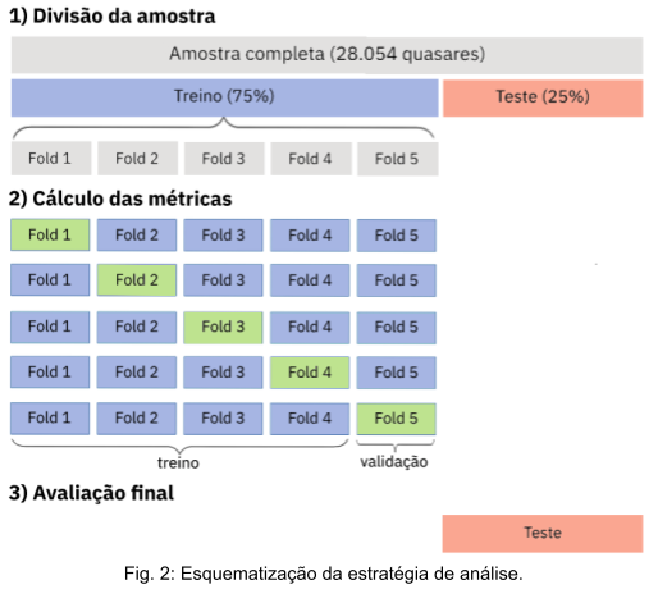

In [6]:
# Esquematização da divisão da amostra
from IPython.display import Image
Image("data_splitting.png", width = 400, height = 200)

In [3]:
# 67 colunas a mais que o banco de dados que usava antes
trainfold0.shape[1]

625

In [7]:
trainfold0.shape[0]+validationfold0.shape[0]

20517

In [8]:
# Verificando o intervalo da banda r_iso
pd.concat([trainfold0['r_iso'].describe(),
           trainfold1['r_iso'].describe(),
           trainfold2['r_iso'].describe(),
           trainfold3['r_iso'].describe(),
           trainfold4['r_iso'].describe(),
           validationfold0['r_iso'].describe(),
           validationfold1['r_iso'].describe(),
           validationfold2['r_iso'].describe(),
           validationfold3['r_iso'].describe(),
           validationfold4['r_iso'].describe()], axis=1)

,r_iso,r_iso,r_iso,r_iso,r_iso,r_iso,r_iso,r_iso,r_iso,r_iso
count,16399.000000,16402.000000,16403.000000,16404.000000,16400.000000,4103.000000,4100.000000,4099.000000,4098.000000,4102.000000
mean,20.723596,20.725993,20.720972,20.717722,20.724424,20.718325,20.708733,20.728821,20.741832,20.715013
std,0.916784,0.917595,0.918316,0.920773,0.912950,0.919392,0.916032,0.913241,0.903048,0.934496
min,15.399064,15.439690,15.399064,15.399064,15.399064,15.542830,15.399064,15.439690,16.437181,15.551054
25%,20.170027,20.169687,20.169656,20.168970,20.181779,20.177222,20.179999,20.180906,20.192614,20.139123
50%,20.889475,20.895566,20.887457,20.887714,20.891255,20.893751,20.866538,20.906725,20.902714,20.888114
75%,21.456095,21.455864,21.447852,21.445717,21.449716,21.435050,21.436702,21.464296,21.469275,21.456710
max,21.999947,21.999947,21.999947,21.999947,21.999794,21.999458,21.999084,21.999594,21.999794,21.999947


In [9]:
# Verificando o intervalo do redshift
pd.concat([trainfold0['Z'].describe(),
           trainfold1['Z'].describe(),
           trainfold2['Z'].describe(),
           trainfold3['Z'].describe(),
           trainfold4['Z'].describe(),
           validationfold0['Z'].describe(),
           validationfold1['Z'].describe(),
           validationfold2['Z'].describe(),
           validationfold3['Z'].describe(),
           validationfold4['Z'].describe()], axis=1)

,Z,Z,Z,Z,Z,Z,Z,Z,Z,Z
count,16413.000000,16413.000000,16414.000000,16414.000000,16414.000000,4104.000000,4104.000000,4103.000000,4103.000000,4103.000000
mean,1.621969,1.621667,1.622425,1.621623,1.621371,1.621180,1.622387,1.619355,1.622563,1.623570
std,0.756927,0.757089,0.757353,0.756156,0.756735,0.756623,0.755973,0.754909,0.759700,0.757388
min,0.034357,0.034357,0.058000,0.034357,0.034357,0.085000,0.060000,0.034357,0.086661,0.058000
25%,1.055000,1.058785,1.058198,1.057000,1.056591,1.064895,1.053910,1.053423,1.056855,1.059704
50%,1.540882,1.538583,1.536436,1.540000,1.538069,1.532064,1.538904,1.546375,1.534165,1.543159
75%,2.090864,2.090764,2.093043,2.089928,2.092505,2.090549,2.093468,2.089048,2.101429,2.087867
max,6.999202,6.999202,6.999202,6.981287,6.999202,6.957502,6.701882,6.767416,6.999202,6.981287


Vemos que os dados já estão filtrados com $0 < Z \le 7$ e $r \ge 22$.

Vamos filtrar as colunas para tomarmos apenas as 12 bandas S-PLUS (iso) + bandas WISE + bandas GALEX, fazer a tratativa dos valores NaN substituindo pelo valor 99 e, depois, calcular as cores.

In [10]:
aper = "iso" # abertura isofótica
specz = "Z" # espectro Z

feat_broad = ['u', 'g', 'r', 'i', 'z'] # banda larga
feat_narrow = ['J0378', 'J0395', 'J0410', 'J0430', 'J0515', 'J0660', 'J0861'] # banda estreita

feat = feat_broad+feat_narrow
splus = [item+"_"+aper for item in feat]

# Magnitudes
wise = ["W1_MAG", "W2_MAG"]
galex = ['FUVmag', 'NUVmag']

# Colunas
cols = splus+wise+galex+['index','Z']

In [11]:
# Filtrando as colunas que serão utilizada inicialmente
trainf0 = trainfold0[cols]
trainf1 = trainfold1[cols]
trainf2 = trainfold2[cols]
trainf3 = trainfold3[cols]
trainf4 = trainfold4[cols]

validf0 = validationfold0[cols]
validf1 = validationfold1[cols]
validf2 = validationfold2[cols]
validf3 = validationfold3[cols]
validf4 = validationfold4[cols]

In [12]:
%%capture --no-display
# Imputando os valores NaN pelo valor 99
trainf0.fillna(99, inplace = True)
trainf1.fillna(99, inplace = True)
trainf2.fillna(99, inplace = True)
trainf3.fillna(99, inplace = True)
trainf4.fillna(99, inplace = True)

validf0.fillna(99, inplace = True)
validf1.fillna(99, inplace = True)
validf2.fillna(99, inplace = True)
validf3.fillna(99, inplace = True)
validf4.fillna(99, inplace = True)

In [13]:
features=OrderedDict()
features = {"wise": None,
            "splus": {"broad": None, "narrow": None},
            "galex": None}

features["wise"] = {"W1_MAG": 34000, "W2_MAG": 46000}

features["galex"] = {'FUVmag': 1528, 'NUVmag': 2310}

features["splus"]["broad"] =  {'u': 3536, 'g': 4751, 'r': 6258, 'i': 7690, 'z': 8831}

features["splus"]["narrow"] = {'J0378': 3770, 'J0395': 3940, 'J0410': 4094, 'J0430': 4292, 
                               'J0515': 5133, 'J0660': 6614, 'J0861': 8611}

features["splus"]["broad"] = {k+"_"+aper:v for k,v in features["splus"]["broad"].items()}
features["splus"]["narrow"] = {k+"_"+aper:v for k,v in features["splus"]["narrow"].items()}

In [14]:
# Define as cores
def create_colors(broad, narrow, wise, galex):
    colors = []
    ref_key = "r"+"_"+aper # aqui ele faz (mag - R_iso) ou (R_iso - mag), ou seja, (banda mais azul) - (banda mais vermelha)
    ref = 6258
    
    list_features = []

    if broad == True:
        list_features = list_features+list(features["splus"]["broad"])
    
    if narrow == True:
        list_features = list_features+list(features["splus"]["narrow"])
    
    if wise == True:
        list_features = list_features+list(features["wise"])

    if galex == True:
        list_features = list_features+list(features["galex"])

    # list_features = list(features["splus"]["broad"])+list(features["splus"]["narrow"])+ \
    #                 list(features["galex"])+ list(features["wise"])
    try:
        list_features.remove(ref_key)
    except:
        pass

    for key in list_features:
        try:
            if features["splus"]["broad"][key] < ref:
                colors.append(key + "-"+ ref_key)
            else:
                colors.append(ref_key + "-" + key)
        except:
            None
        try:
            if features["splus"]["narrow"][key] < ref:
                colors.append(key + "-"+ ref_key)
            else:
                colors.append(ref_key + "-" + key)
        except:
            None
        try:
            if features["wise"][key] < ref:
                colors.append(key + "-"+ ref_key)
            else:
                colors.append(ref_key + "-" + key)
        except:
            None
        try:
            if features["galex"][key] < ref:
                colors.append(key + "-"+ ref_key)
            else:
                colors.append(ref_key + "-" + key)
        except:
            None

    return colors

In [15]:
# Calcula as cores
def calculate_colors(data, broad, narrow, wise, galex):
    colors = create_colors(broad=broad, narrow=narrow, wise=wise, galex=galex)
    for c in colors:
        aux = c.split("-")
        data[c] = data[aux[0]] - data[aux[1]]
    return data

In [16]:
%%capture --no-display
calculate_colors(data=trainf0, broad=True, narrow=True, wise=True, galex=True)
calculate_colors(data=trainf1, broad=True, narrow=True, wise=True, galex=True)
calculate_colors(data=trainf2, broad=True, narrow=True, wise=True, galex=True)
calculate_colors(data=trainf3, broad=True, narrow=True, wise=True, galex=True)
calculate_colors(data=trainf4, broad=True, narrow=True, wise=True, galex=True)

calculate_colors(data=validf0, broad=True, narrow=True, wise=True, galex=True)
calculate_colors(data=validf1, broad=True, narrow=True, wise=True, galex=True)
calculate_colors(data=validf2, broad=True, narrow=True, wise=True, galex=True)
calculate_colors(data=validf3, broad=True, narrow=True, wise=True, galex=True)
calculate_colors(data=validf4, broad=True, narrow=True, wise=True, galex=True)

,u_iso,g_iso,r_iso,i_iso,z_iso,J0378_iso,J0395_iso,J0410_iso,J0430_iso,J0515_iso,...,J0395_iso-r_iso,J0410_iso-r_iso,J0430_iso-r_iso,J0515_iso-r_iso,r_iso-J0660_iso,r_iso-J0861_iso,r_iso-W1_MAG,r_iso-W2_MAG,FUVmag-r_iso,NUVmag-r_iso
0,22.249907,22.282442,21.871273,21.782484,21.863014,22.233189,23.026987,22.918625,23.395160,22.090454,...,1.155714,1.047352,1.523887,0.219181,0.152403,0.417545,4.629427,5.581610,77.128727,77.128727
1,99.000000,22.123117,21.007187,20.939537,20.168657,22.140205,99.000000,99.000000,21.332928,99.000000,...,77.992813,77.992813,0.325741,77.992813,-0.221537,0.849581,4.996491,5.847838,77.992813,1.041013
2,22.532679,22.106468,21.684052,21.463993,21.350449,22.541435,22.483494,21.909424,23.050737,22.089437,...,0.799442,0.225372,1.366685,0.405385,-0.547088,0.399933,4.712763,6.052628,77.315948,0.694548
3,21.301197,21.006031,20.490602,20.279905,20.279790,21.498032,21.516218,21.320047,20.679450,21.045416,...,1.025616,0.829445,0.188848,0.554814,0.026474,-0.221900,4.236858,5.627734,78.509398,1.437698
4,21.265636,20.821362,20.824308,20.719593,20.483154,21.061195,21.710915,20.339815,20.609920,20.937658,...,0.886607,-0.484493,-0.214388,0.113350,0.093662,0.347678,3.873128,5.244955,78.175692,78.175692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4098,22.952578,21.580929,21.448515,21.408466,21.580183,21.747215,21.383234,21.839573,22.601116,22.112585,...,-0.065281,0.391058,1.152601,0.664070,0.041697,0.193123,4.629679,4.822891,77.551485,77.551485
4099,20.958586,19.736347,18.965565,18.450315,18.092290,20.231264,20.102812,20.132647,20.358328,19.609177,...,1.137247,1.167082,1.392763,0.643612,0.168379,0.757227,5.308586,6.470774,80.034435,2.515735
4100,21.814827,21.564632,21.303790,21.283768,20.891006,22.346626,21.489912,21.176155,21.732052,21.513353,...,0.186122,-0.127635,0.428262,0.209563,-0.081990,0.414092,3.452313,4.550841,77.696210,77.696210
4101,23.662533,22.213997,21.842024,21.844763,21.202538,99.000000,22.625683,22.656225,22.374895,21.505530,...,0.783659,0.814201,0.532871,-0.336494,-0.559679,0.499659,4.561258,4.387789,77.157976,77.157976


In [17]:
# Reodernando as colunas
colors = create_colors(broad=True, narrow=True, wise=True, galex=True)
trainf0 = trainf0[colors+['r_iso','Z','index']]
trainf1 = trainf1[colors+['r_iso','Z','index']]
trainf2 = trainf2[colors+['r_iso','Z','index']]
trainf3 = trainf3[colors+['r_iso','Z','index']]
trainf4 = trainf4[colors+['r_iso','Z','index']]

validf0 = validf0[colors+['r_iso','Z','index']]
validf1 = validf1[colors+['r_iso','Z','index']]
validf2 = validf2[colors+['r_iso','Z','index']]
validf3 = validf3[colors+['r_iso','Z','index']]
validf4 = validf4[colors+['r_iso','Z','index']]

In [18]:
trainf0.columns

Index(['u_iso-r_iso', 'g_iso-r_iso', 'r_iso-i_iso', 'r_iso-z_iso',
       'J0378_iso-r_iso', 'J0395_iso-r_iso', 'J0410_iso-r_iso',
       'J0430_iso-r_iso', 'J0515_iso-r_iso', 'r_iso-J0660_iso',
       'r_iso-J0861_iso', 'r_iso-W1_MAG', 'r_iso-W2_MAG', 'FUVmag-r_iso',
       'NUVmag-r_iso', 'r_iso', 'Z', 'index'],
      dtype='object')

Agora, vamos ajustar o modelo para cada amostra.

In [19]:
# Ajuste do modelo
model_v1 = RandomForestRegressor(random_state = 47)

In [20]:
# Treinamento e predição no conjunto de validação
model_v1.fit(trainf0.drop(['Z','index'], axis=1).values, trainf0['Z'].values)
predf0 = model_v1.predict(validf0.drop(['Z','index'], axis=1).values)

model_v1.fit(trainf1.drop(['Z','index'], axis=1).values, trainf1['Z'].values)
predf1 = model_v1.predict(validf1.drop(['Z','index'], axis=1).values)

model_v1.fit(trainf2.drop(['Z','index'], axis=1).values, trainf2['Z'].values)
predf2 = model_v1.predict(validf2.drop(['Z','index'], axis=1).values)

model_v1.fit(trainf3.drop(['Z','index'], axis=1).values, trainf3['Z'].values)
predf3 = model_v1.predict(validf3.drop(['Z','index'], axis=1).values)

model_v1.fit(trainf4.drop(['Z','index'], axis=1).values, trainf4['Z'].values)
predf4 = model_v1.predict(validf4.drop(['Z','index'], axis=1).values)

In [21]:
df_result = pd.DataFrame({'index':np.concatenate((validf0['index'],validf1['index'],validf2['index'],
                                                  validf3['index'],validf4['index']),axis=0),
                          'z_pred':np.concatenate((predf0,predf1,predf2,predf3,predf4),axis=0),
                          'Z':np.concatenate((validf0['Z'],validf1['Z'],validf2['Z'],
                                              validf3['Z'],validf4['Z']),axis=0),
                          'r_iso':np.concatenate((validf0['r_iso'],validf1['r_iso'],validf2['r_iso'],
                                                  validf3['r_iso'],validf4['r_iso']),axis=0),
                          'fold':[0]*len(validf0)+[1]*len(validf1)+[2]*len(validf2)+
                                 [3]*len(validf3)+[4]*len(validf4)})

In [22]:
df_result.head()

,index,z_pred,Z,r_iso,fold
0,22721,3.020843,2.554000,21.761778,0
1,32648,2.135439,2.103000,19.391685,0
2,14359,1.637386,0.817000,21.719425,0
3,31326,2.030137,1.810274,21.316881,0
4,18007,1.777249,1.693000,20.141329,0


In [23]:
len(df_result)

20517

In [24]:
# Importando os resultados da amostra de validação
result_val = pd.read_csv("database/z_792", sep = ',')

In [25]:
result_val.head()

,index,z_pred,Z,r_iso,fold
0,22721,3.034151,2.554000,21.761778,0
1,32648,2.153188,2.103000,19.391685,0
2,14359,1.647609,0.817000,21.719425,0
3,31326,2.039495,1.810274,21.316881,0
4,18007,1.775105,1.693000,20.141329,0


In [26]:
len(result_val['z_pred'])

20517

In [27]:
# Analisando a diferença média das predições
abs(df_result['z_pred']-result_val['z_pred']).mean()

0.013994436073317936